In [64]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [50]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  Quadro P1000
Using device: cuda


In [51]:
# Load data
train_data = pd.read_csv('dataset/electricity_consump/electricity_train.csv')
test_data = pd.read_csv('dataset/electricity_consump/electricity_test.csv')

# Define the sequence length
seq_length = 96

# Function to create sequences & define features and labels
def create_sequences(df, seq_length):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df.iloc[i:(i + seq_length), 1]
        y = df.iloc[i + seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create training and test sequences
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

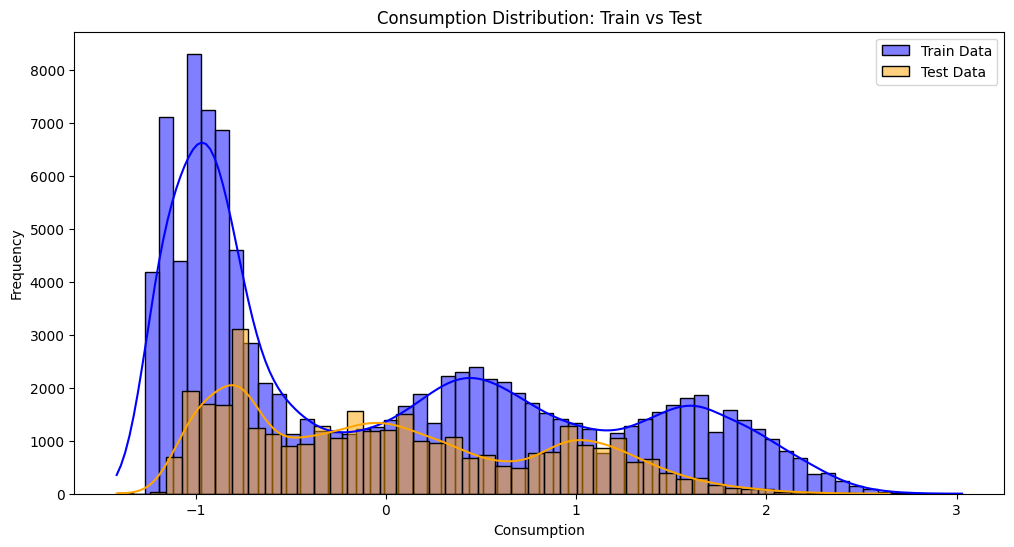

In [ ]:
import seaborn as sns 

plt.figure(figsize=(12, 6))
sns.histplot(train_data['consumption'], kde=True, color='blue', label='Train Data')
sns.histplot(test_data['consumption'], kde=True, color='orange', label='Test Data')
plt.title('Consumption Distribution: Train vs Test')
plt.xlabel('Consumption')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [52]:
# Data into TensorDataset
dataset_train = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
)
dataset_test = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float(),
)

In [53]:
# DataLoader
train_dataloader = DataLoader(dataset_train, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(dataset_test, shuffle=False, batch_size=64, drop_last=True)

## Data Prep 

In [54]:
print(f"Train Data Head: \n {train_data.head()} \n")
print(f"Train Data Tail: \n{train_data.tail()}\n")
print(f"Test Data Head: \n{test_data.head()}\n")
print(f"Test Data Tail: \n{test_data.tail()}")

Train Data Head: 
              timestamp  consumption
0  2011-01-01 00:15:00    -0.704319
1  2011-01-01 00:30:00    -0.704319
2  2011-01-01 00:45:00    -0.678983
3  2011-01-01 01:00:00    -0.653647
4  2011-01-01 01:15:00    -0.704319 

Train Data Tail: 
                  timestamp  consumption
105210  2013-12-31 22:45:00    -0.932595
105211  2013-12-31 23:00:00    -0.907259
105212  2013-12-31 23:15:00    -0.932595
105213  2013-12-31 23:30:00    -0.932595
105214  2013-12-31 23:45:00    -0.932595

Test Data Head: 
             timestamp  consumption
0  2014-01-01 00:00:00    -0.932595
1  2014-01-01 00:15:00    -0.957931
2  2014-01-01 00:30:00    -0.932595
3  2014-01-01 00:45:00    -0.907259
4  2014-01-01 01:00:00    -0.881923

Test Data Tail: 
                 timestamp  consumption
35035  2014-12-31 22:45:00    -0.070415
35036  2014-12-31 23:00:00    -0.045079
35037  2014-12-31 23:15:00    -0.045079
35038  2014-12-31 23:30:00    -0.045079
35039  2014-12-31 23:45:00    -0.095751


## RNN / LSTM / GRU

In [56]:
# LSTM Model
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1, 
            hidden_size=64, 
            num_layers=2, 
            batch_first=True,
        )
        self.fc = nn.Linear(64, 1)
    def forward(self, x): 
        h0 = torch.zeros(2, x.size(0), 64).to(device)
        c0 = torch.zeros(2, x.size(0), 64).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [57]:
for seqs, labels in train_dataloader: 
    print(seqs.shape)

torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([6

In [58]:
# Initialize Model, Criterion, Optimizer
net = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [ ]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs): 
    epoch_loss = 0
    for seqs, labels in train_dataloader:
        batch_size = seqs.size(0)
        seqs = seqs.view(batch_size, seq_length, 1).to(device)
        labels = labels.to(device)

        outputs = net(seqs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_dataloader):.4f}")


c:\Users\mahum\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 1.1182
Epoch [2/10], Loss: 1.1180
Epoch [3/10], Loss: 1.1177
Epoch [4/10], Loss: 1.1177
Epoch [5/10], Loss: 1.1179
Epoch [6/10], Loss: 1.1178
Epoch [7/10], Loss: 1.1178
Epoch [8/10], Loss: 1.1176
Epoch [9/10], Loss: 1.1178
Epoch [10/10], Loss: 1.1178


In [69]:
# Testing Loop
net.eval()
test_loss = 0
predicted = []
actual = []
with torch.no_grad():
    for seqs, labels in test_dataloader:
        batch_size = seqs.size(0)
        seqs = seqs.view(batch_size, seq_length, 1).to(device)
        labels = labels.to(device)

        outputs = net(seqs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted.extend(outputs.cpu().numpy())  
        actual.extend(labels.cpu().numpy())  # Store actual values

print(f"Test Loss with LSTM: {test_loss / len(test_dataloader):.4f}")
print(f"Predicted: {predicted}")
print(f"Actual Valued: {actual}")

c:\Users\mahum\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss with LSTM: 0.6410
Predicted: [array([-0.03501733], dtype=float32), array([-0.03501722], dtype=float32), array([-0.03501736], dtype=float32), array([-0.03501733], dtype=float32), array([-0.03494722], dtype=float32), array([-0.0350102], dtype=float32), array([-0.03501401], dtype=float32), array([-0.03505088], dtype=float32), array([-0.03502041], dtype=float32), array([-0.03501906], dtype=float32), array([-0.03501733], dtype=float32), array([-0.03501748], dtype=float32), array([-0.0350173], dtype=float32), array([-0.03501733], dtype=float32), array([-0.03501732], dtype=float32), array([-0.03501733], dtype=float32), array([-0.03501732], dtype=float32), array([-0.03501733], dtype=float32), array([-0.03494721], dtype=float32), array([-0.03489716], dtype=float32), array([-0.03488737], dtype=float32), array([-0.03488508], dtype=float32), array([-0.03484226], dtype=float32), array([-0.03487734], dtype=float32), array([-0.03488275], dtype=float32), array([-0.03488417], dtype=float32), 

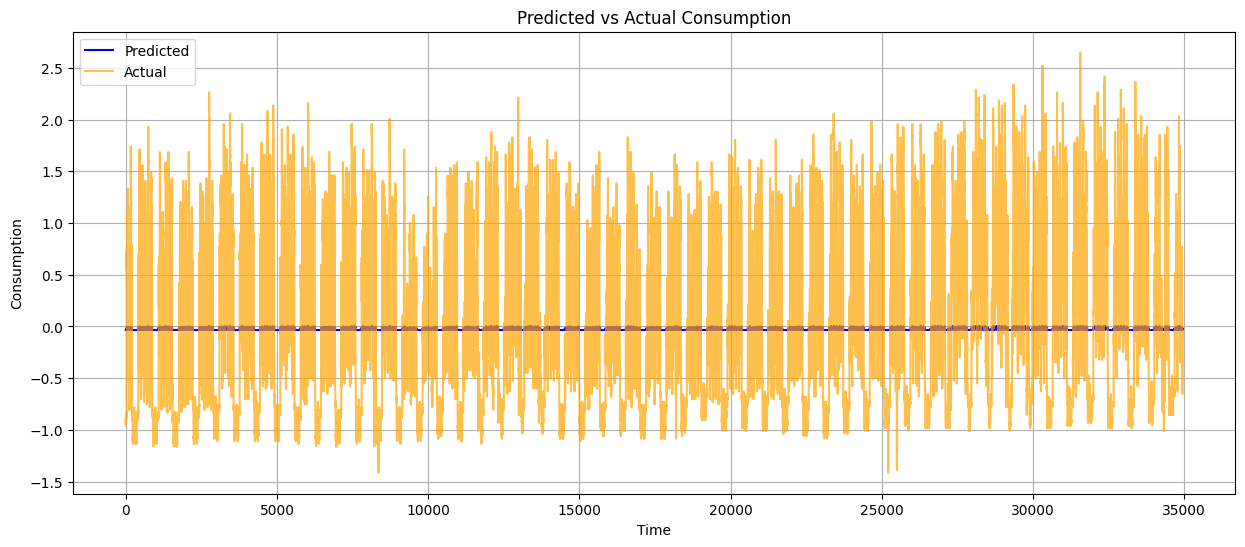

In [70]:
# Assuming `predicted` and `actual` are available
plt.figure(figsize=(15, 6))
plt.plot(predicted, label='Predicted', color='blue')
plt.plot(actual, label='Actual', color='orange', alpha=0.7)
plt.title('Predicted vs Actual Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
print(seqs.shape)

torch.Size([64, 96, 1])
